# Inplementation

In [7]:
NumDataPerClass = 200
# Two-class problem, distinct means, equal covariance matrices
#
m1 = [[0, 5]]
m2 = [[5, 0]]
C = [[2, 1], [1, 2]]
# Set up the data by generating isotropic Guassians and
# rotating them accordingly
#
A = np.linalg.cholesky(C)
U1 = np.random.randn(NumDataPerClass,2)
X1 = U1 @ A.T + m1
U2 = np.random.randn(NumDataPerClass,2)
X2 = U2 @ A.T + m2

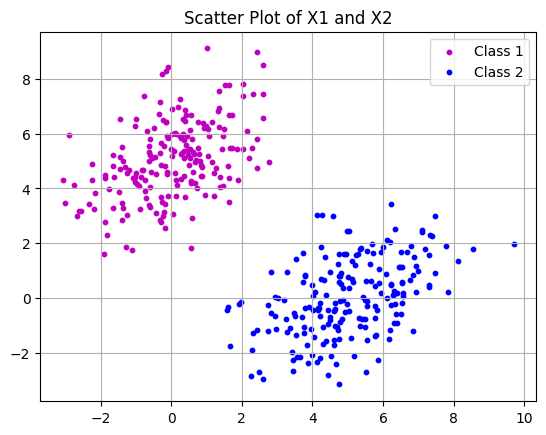

In [13]:
import matplotlib.pyplot as plt

# Plot the first dataset (X1)
plt.scatter(X1[:, 0], X1[:, 1], label="Class 1", color="m", s = 10)

# Plot the second dataset (X2)
plt.scatter(X2[:, 0], X2[:, 1], label="Class 2", color="b", s = 10)

# Add labels and title

plt.title("Scatter Plot of X1 and X2")
plt.grid()

# Add legend
plt.legend()

# Show the plot
plt.show()

# 2

In [21]:
X = np.concatenate((X1, X2), axis=0)

# 3

In [22]:
labelPos = np.ones(NumDataPerClass)
labelNeg = -1.0 * np.ones(NumDataPerClass)
y = np.concatenate((labelPos, labelNeg))

# 4

In [23]:
rIndex = np.random.permutation(2*NumDataPerClass)
Xr = X[rIndex,]
yr = y[rIndex]
# Training and test sets (half half)
#
X_train = Xr[0:NumDataPerClass]
y_train = yr[0:NumDataPerClass]
X_test = Xr[NumDataPerClass:2*NumDataPerClass]
y_test = yr[NumDataPerClass:2*NumDataPerClass]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
Ntrain = NumDataPerClass;
Ntest = NumDataPerClass;


(200, 2) (200,) (200, 2) (200,)


# 5

In [24]:
def PercentCorrect(Inputs, targets, weights):
    N = len(targets)
    nCorrect = 0
    for n in range(N):
        OneInput = Inputs[n,:]
        if (targets[n] * np.dot(OneInput, weights) > 0):
            nCorrect +=1
    return 100*nCorrect/N

# 6

In [25]:
# Perceptron learning loop
#
# Random initialization of weights
#
w = np.random.randn(2)
print(w)
# What is the performance with the initial random weights?
#
print("Initial Percentage Correct: %6.2f" %(PercentCorrect(X_train, y_train, w)))
# Fixed number of iterations (think of better stopping criterion)
#
MaxIter=1000
# Learning rate (change this to see convergence changing)
#
alpha = 0.002
# Space to save answers for plotting
#
P_train = np.zeros(MaxIter)
P_test = np.zeros(MaxIter)
# Main Loop
#
for iter in range(MaxIter):
    # Select a data item at random
    #
    r = np.floor(np.random.rand()*Ntrain).astype(int)
    x = X_train[r,:]
    # If it is misclassified, update weights
    #
    if (y_train[r] * np.dot(x, w) < 0):
        w += alpha * y_train[r] * x
    # Evaluate trainign and test performances for plotting
    #
    P_train[iter] = PercentCorrect(X_train, y_train, w);
    P_test[iter] = PercentCorrect(X_test, y_test, w);
print("Percentage Correct After Training: %6.2f %6.2f"%(PercentCorrect(X_train, y_train, w), PercentCorrect(X_test, y_test, w)))


[-0.42957782 -0.95413592]
Initial Percentage Correct:  44.00
Percentage Correct After Training: 100.00  99.00


# 7

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(range(MaxIter), P_train, 'b', label = "Training")
ax.plot(range(MaxIter), P_test, 'r', label = "Test")
ax.grid(True)
ax.legend()
ax.set_title('Perceptron Learning')
ax.set_ylabel('Training and Test Accuracies', fontsize=14)
ax.set_xlabel('Iteration', fontsize=14)
plt.savefig('learningCurves.png')


# 8

In [30]:
# Scikitlearn can do it for us
#
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
model = Perceptron()
model.fit(X_train, y_train)
yh_train = model.predict(X_train)
print("Accuracy on training set: %6.2f" %(accuracy_score(yh_train, y_train)))
yh_test = model.predict(X_test)
print("Accuracy on test set: %6.2f" %(accuracy_score(yh_test, y_test)))
if (accuracy_score(yh_test, y_test) > 0.99):
    print("Wow, Perfect Classification on Separable dataset!")


Accuracy on training set:   1.00
Accuracy on test set:   1.00
Wow, Perfect Classification on Separable dataset!


# 10

In [33]:
import pandas as pd
import numpy as np
from random import seed, randrange
from sklearn.preprocessing import StandardScaler

# Load a CSV file using pandas
def load_csv(filename):
    return pd.read_csv(filename, header=None)

# Convert string column to float
def str_column_to_float(dataset, column):
    dataset[column] = dataset[column].astype(float)

# Convert string column to integer
def str_column_to_int(dataset, column):
    dataset[column] = dataset[column].astype('category').cat.codes

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = []
    dataset_copy = dataset.copy()
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = pd.DataFrame(columns=dataset.columns)
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold = fold.append(dataset_copy.iloc[index])
            dataset_copy = dataset_copy.drop(index).reset_index(drop=True)  # Resetting index after drop
        dataset_split.append(fold)
    return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = (actual == predicted).sum()
    return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = []
    for fold_index, fold in enumerate(folds):
        train_set = pd.concat([f for i, f in enumerate(folds) if i != fold_index])
        test_set = fold.copy()
        test_set.iloc[:, -1] = None
        predicted = algorithm(train_set.values, test_set.values, *args)
        actual = fold.iloc[:, -1].values
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

# Make a prediction with weights
def predict(row, weights):
    activation = weights[0] + np.dot(row[:-1], weights[1:])
    return 1.0 if activation >= 0.0 else 0.0

# Estimate Perceptron weights using stochastic gradient descent
def train_weights(train, l_rate, n_epoch):
    weights = np.zeros(len(train[0]))
    for epoch in range(n_epoch):
        for row in train:
            prediction = predict(row, weights)
            error = row[-1] - prediction
            weights[0] += l_rate * error
            weights[1:] += l_rate * error * row[:-1]
    return weights

# Perceptron Algorithm With Stochastic Gradient Descent
def perceptron(train, test, l_rate, n_epoch):
    predictions = []
    weights = train_weights(train, l_rate, n_epoch)
    for row in test:
        prediction = predict(row, weights)
        predictions.append(prediction)
    return predictions

# Test the Perceptron algorithm on the Iris dataset
seed(1)
# load and prepare data
filename = 'iris.data'  # change this to the path of your Iris dataset
dataset = load_csv(filename)
for i in range(dataset.shape[1]-1):
    str_column_to_float(dataset, i)
# convert string class to integers
str_column_to_int(dataset, dataset.shape[1]-1)

# normalize the dataset
scaler = StandardScaler()
dataset.iloc[:, :-1] = scaler.fit_transform(dataset.iloc[:, :-1])

# evaluate algorithm
n_folds = 3
l_rate = 0.05  # Adjust the learning rate
n_epoch = 1000  # Adjust the number of epochs
scores = evaluate_algorithm(dataset, perceptron, n_folds, l_rate, n_epoch)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))


<ipython-input-33-a78ce93e5163>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fold = fold.append(dataset_copy.iloc[index])
<ipython-input-33-a78ce93e5163>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fold = fold.append(dataset_copy.iloc[index])
<ipython-input-33-a78ce93e5163>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fold = fold.append(dataset_copy.iloc[index])
<ipython-input-33-a78ce93e5163>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fold = fold.append(dataset_copy.iloc[index])
<ipython-input-33-a78ce93e5163>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

Scores: [66.0, 60.0, 70.0]
Mean Accuracy: 65.333%
